In [0]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import cv2
import os

import matplotlib.pyplot as plt

from datetime import datetime

from torchsummary import summary

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid

from sklearn.metrics import average_precision_score, auc

In [2]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

BASE_PATH = os.getcwd() + '/gdrive/My Drive/Colab Notebooks/CIS680/HW2'
DATA_PATH = os.path.join(BASE_PATH, 'data')
CHECKPOINT_PATH = os.path.join(BASE_PATH, 'checkpoints')
RANDOM_SEED = 777

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Mounted at /content/gdrive


# Helper Functions

#### Width/Height and Center Offsets

In [0]:
def width_height_perc(x1, y1, x2, y2, image_size=128):
  w = x2 - x1
  h = y2 - y1
  w_perc = w / image_size
  h_perc = h / image_size
  
  return w_perc, h_perc


def width_height_from_labels(labels):
  width_height_fn= lambda row: width_height_perc(*row)
  wh = np.apply_along_axis(width_height_fn, 1, labels[:, 1:])
  return wh


def offset_to_top_left_1d_perc(anchor, bbox_center, grid_size=16):
  x_c, y_c = bbox_center
  # Anchor top_left
  x_a, y_a = (anchor * grid_size)
  
  x_offset = (x_c - x_a) / grid_size
  y_offset = (y_c - y_a) / grid_size
  return x_offset, y_offset

  
def centers_to_top_left_offsets(anchors, bbox_centers):
  offsets = np.empty([anchors.shape[0], 2], dtype=float)
  
  for i in range(anchors.shape[0]):
    offsets[i] = offset_to_top_left_1d_perc(anchors[i], bbox_centers[i])
    
  return offsets

#### Image centers and anchor boxes

In [0]:
def image_center(x1, y1, x2, y2):
  """Returns the center of a pair of coordinates"""
  x_c = (x1 + x2) / 2.
  y_c = (y1 + y2) / 2.
  return x_c, y_c

def anchor_box_from_center(x_c, y_c, grid_cell_size=16):
  """Returns the index of the anchor box in the output given the center"""
  x_a = int(x_c // grid_cell_size)
  y_a = int(y_c // grid_cell_size)
  return x_a, y_a

def anchor_box_from_bbox(bbox):
  return anchor_box_from_center(*image_center(*bbox))

#### Area and IoU

In [0]:
def area(x1, y1, x2, y2):
  return (x2 - x1) * (y2 - y1)


def get_iou(box1, box2, eps=1e-5):
  
  x1_a, y1_a, x2_a, y2_a = box1
  x1_b, y1_b, x2_b, y2_b = box2
  
  box1_area = area(*box1)
  box2_area = area(*box2)
  
  x1 = max(x1_a, x1_b)
  y1 = max(y1_a, y1_b)
  x2 = min(x2_a, x2_b)
  y2 = min(y2_a, y2_b)
   
  if (x2 - x1 < 0.) or (y2 - y1 < 0.):
    overlap_area = 0.
  else:
    overlap_area = area(x1, y1, x2, y2)
    
  combined_area = box1_area + box2_area - overlap_area
  
  iou = overlap_area / (combined_area + eps)
   
  return iou

### Higher-Order to Apply Helpers

In [0]:
def image_centers_from_labels(labels):
  
  image_center_fn = lambda row: image_center(*row)
  image_centers = np.apply_along_axis(image_center_fn, 1, labels[:, 1:])
  
  return image_centers

def anchors_from_labels(labels):
  
  anchors = np.apply_along_axis(anchor_box_from_bbox, 1, labels[:, 1:])
  
  return anchors


def unique_anchor_inds(labels):
  
  anchors = np.apply_along_axis(anchor_box_from_bbox, 1, labels[:, 1:])
  
  # Referencing the TAs response on Piazza, only allows one object per anchor box
  # Throws away all any conflicts to enforce
  _, unique_anchor_inds = np.unique(anchors, axis=0, return_index=True)

  unique_anchor_inds = np.sort(unique_anchor_inds)
  
  return unique_anchor_inds

  

In [0]:
def perc_to_width_height(w_perc, h_perc, image_size=128):
  return w_perc * image_size, h_perc * image_size


def perc_to_offset_top_left(x_offset_perc, y_offset_perc, grid_size=16):
  return x_offset_perc, y_offset_perc

### Visualization Helpers

In [0]:
CLASS_COLOR_MAP = {
    0: (255, 0, 0), # Pedestrian
    1: (0, 0, 255), # Stoplight
    2: (0, 255, 0) # Car
}

def draw_bounding_boxes_dataset(dataset, index):
  """Returns a copy of the image at index with object boundaries drawn
  
  e.g. plt.imshow(draw_bounding_boxes_dataset(hw2_dataset, 5))
  
  """
  image = dataset.images[index]
  labels = dataset.dense_labels[index]
  
  viz = draw_bounding_boxes(image, labels)
  
  return viz


def draw_bounding_boxes(image, labels):
    """Draw bounding boxes onto image. Returns copy of image. """
    ret_copy = np.copy(image)
    for idx in range(labels.shape[0]):
    
      c1 = tuple(labels[idx, 1:3].astype(int))
      c2 = tuple(labels[idx, 3:5].astype(int))
      
      cv2.rectangle(ret_copy, c1, c2, CLASS_COLOR_MAP[labels[idx, 0]] , 1)

    return ret_copy

# Main Preprocess Routine

In [0]:
def labels_to_dense_yolo_labels(labels):
  """Transforms a set of sparse object labels for an image to dense YOLO label.
  
  Parameters
  ----------
  labels -- ndarray
            2D array where each row is an object label (c, x1, y1, x2, y2)
  
  
  Output:
  ndarray with shape [8, 8, 8]
  """
  
  dense_label = np.zeros((8, 8, 8))
  
  if labels.shape[0] == 0:
    return dense_label
  
  # Get the set of labels that map to unique anchors
  anchor_ids = unique_anchor_inds(labels)
  f_labels = labels[anchor_ids]
 
  # List of classes for ease 
  f_classes = f_labels[:, 0].astype(int)
  
  # Corresponding anchors
  f_anchors = anchors_from_labels(f_labels)
  
  # Corresponding image centers
  f_centers = image_centers_from_labels(f_labels)
  
  # Corresponding center offsets
  f_offsets = centers_to_top_left_offsets(f_anchors, f_centers)
  
  # Corresponding heights and widths of bounding boxes
  f_wh = width_height_from_labels(f_labels)
  
  for i in range(f_labels.shape[0]):
    
    r, c = f_anchors[i]    
    
    # Anchor has object
    dense_label[0, c, r] = 1.
    dense_label[1:3, c, r] = f_offsets[i]
    dense_label[3:5, c, r] = f_wh[i]
    
    # De-facto one-hot encoding
    # class channels start at index 5. set true class to value 1.
    dense_label[5 + f_classes[i], c, r] = 1.
  
  return dense_label
  
  

## Run the Preprocessing

Sub-routine that converts the original dense labels into YOLO labels. This code is commented because I saved the YOLO labels to prevent re-computation.

In [0]:
# dense_yolo_labels = np.empty_like(hw2_dataset.labels)

# for i in range(len(hw2_dataset)):
#     labels = hw2_dataset.dense_labels[i]
#     dense_yolo_labels[i] = labels_to_dense_yolo_labels(labels)
    
# np.savez(os.path.join(DATA_PATH, "yolo_labels.npz"), dense_yolo_labels)

# Dataset Loader

In [0]:
class HW2Dataset(torch.utils.data.Dataset):
  def __init__(self, path):
    
    self.dense_labels_path = os.path.join(path, 'labels.npz')
    self.labels_path = os.path.join(path, 'yolo_labels.npz')
    self.images_path = os.path.join(path, 'images.npz')
    
    # Load the YOLO labels
    with np.load(self.labels_path, allow_pickle=True, encoding='bytes') as labels:
      self.labels = labels['arr_0']
    
    # Load the images
    with np.load(self.images_path, allow_pickle=True, encoding='bytes') as images:
      self.images = images['arr_0']
    
    # Load the dense labels (for visualization / debugging)
    with np.load(self.dense_labels_path, allow_pickle=True, encoding='bytes') as dense_labels:
      self.dense_labels = dense_labels['arr_0']
    
    # Sanity check dataset dimensionality
    assert (self.images.shape[0] == self.labels.shape[0])
    
    self.nsamples = self.labels.shape[0]
    
  def __len__(self):
    return self.nsamples
   
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    batch = {
        'index': idx,
        # Provide images channels first
        'image': np.transpose(self.images[idx], (2, 0, 1)),
        'label': self.labels[idx]
    }
    
    return batch

#### Load the dataset

In [0]:
hw2_dataset = HW2Dataset(DATA_PATH)

# YOLONet


#### Construct/Load YOLONet

In [0]:
from torch.nn import Conv2d, BatchNorm2d, ConvTranspose2d
import torch.nn.functional as F
import torch.nn as nn

In [0]:
class YOLONet(nn.Module):
    def __init__(self):
        super(YOLONet, self).__init__()
        self.conv1 = Conv2d(3, 32, 4, stride=2, padding=1)
        self.conv1_bn = BatchNorm2d(32)
        
        self.conv2 = Conv2d(32, 64, 4, stride=2, padding=1)
        self.conv2_bn = BatchNorm2d(64)
        
        self.conv3 = Conv2d(64, 128, 4, stride=2, padding=1)
        self.conv3_bn = BatchNorm2d(128)
        
        self.conv4 = Conv2d(128, 256, 4, stride=2, padding=1)
        self.conv4_bn = BatchNorm2d(256)
        
        self.conv5 = Conv2d(256, 512, 4, stride=2, padding=1)
        self.conv5_bn = BatchNorm2d(512)
        
        self.conv6 = Conv2d(512, 1024, 4, stride=2, padding=1)
        self.conv6_bn = BatchNorm2d(1024)
        
        self.conv7 = ConvTranspose2d(1024, 256, 4, stride=2, padding=1)
        self.conv7_bn = BatchNorm2d(256)
        
        self.conv8 = ConvTranspose2d(256, 64, 4, stride=2, padding=1)
        self.conv8_bn = BatchNorm2d(64)
        
        self.conv9 = Conv2d(64, 8, 3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))        
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))        
        x = F.relu(self.conv7_bn(self.conv7(x)))                
        x = F.relu(self.conv8_bn(self.conv8(x)))                
        x = self.conv9(x)
        return x

#### YOLO Loss Function

In [0]:
class YOLO_loss(nn.Module):
  
  def __init__(self, lam_coord, lam_noobj):
    super(YOLO_loss, self).__init__()
    self.lam_coord = lam_coord
    self.lam_noobj = lam_noobj
    
  def forward(self, y_pred, targ):
    
    OBJ_CH = 0
        
    # no-object mask
    noobj_mask = (targ[:, OBJ_CH] == 0).detach().float()
    
    # object masks in several channel dimensions
    obj_mask = targ[:, OBJ_CH].detach()
    obj_mask_two = torch.unsqueeze(obj_mask, 1).repeat(1,2,1,1).detach()


    obj_mask_three = torch.unsqueeze(obj_mask, 1).repeat(1,3,1,1).detach()
    
    noobj_err = self.lam_noobj * torch.mul(noobj_mask, torch.pow(y_pred[:, OBJ_CH] - targ[:, OBJ_CH], 2))
    noobj_err = noobj_err.view(-1).sum()
        
    obj_err = self.lam_coord * torch.mul(obj_mask, torch.pow(y_pred[:, OBJ_CH] - targ[:, OBJ_CH], 2))
    obj_err = obj_err.view(-1).sum()
    
    obj_xy = self.lam_coord * torch.mul(obj_mask_two, torch.pow(y_pred[:, 1:3] - targ[:, 1:3], 2))
    obj_xy = obj_xy.view(-1).sum()

    
    # Square root blows the gradient up. We can use epsilon to make sure it works    
    eps = torch.zeros(y_pred[:, 3:5].shape, requires_grad=False).uniform_(1e-6, 1e-6).cuda()

    obj_wh = self.lam_coord * torch.mul(obj_mask_two, torch.pow(torch.sqrt(y_pred[:, 3:5] + eps) - torch.sqrt(targ[:, 3:5] + eps), 2))
    obj_wh = obj_wh.view(-1).sum()
    
    obj_class = torch.mul(obj_mask_three, torch.pow(y_pred[:, 5:] - targ[:, 5:], 2))
    obj_class = obj_class.view(-1).sum()      
      
    total_loss = obj_xy + obj_wh + obj_err + noobj_err + obj_class
        
    return total_loss
  

## Inference

In [0]:
def max_iou_from_comp_labels(single_label, comp_labels):
  """Returns the class and IOU value of the ground truth bounding box with max IOU
  
  In: 
    single_label: (5,) - (cl, x1, y1, x2, y2)
    comp_labels: (N, 5) - Matrix of labels. Same as single_label per row
    
  Out: np.array([class_of_max_IOU, max_IOU])
    
  """
  iou_fn = lambda tl: get_iou(single_label[1:], tl)
  
  ious = np.apply_along_axis(iou_fn, 1, comp_labels[:, 1:])
  
  max_iou_id = np.argmax(ious)
  max_iou = ious[max_iou_id]
  
  return max_iou


def precision_recall_from_labels(pred_labels, true_labels, threshold=0.5):
  """Returns the counts of TP, FP, and FN for given thresholds
  
  In:
    pred_labels: np.ndarray(M, 6)
    true_labels: np.ndarray(N, 6)
    
  Out:
    np.ndarray(O, 3) - for each threshold row is [TP, FP, FN]
  """
  RET_PREDS = [None] * 3

  try:
    
    for cl in range(3):

      tl_c = true_labels[true_labels[:, 0] == cl]
      pl_c = pred_labels[pred_labels[:, 0] == cl]

      if pl_c.shape[0] == 0:
        # Everything is a FN
        RET_PREDS[cl] = ([], [], tl_c.shape[0])

      elif tl_c.shape[0] == 0:
        # Everything if a FP
        RET_PREDS[cl] = (np.zeros(pl_c.shape[0]).astype(int), pl_c[:, -1], 0)

      else:
        # Actually compute

        compare_to_ground_truth = lambda label: max_iou_from_comp_labels(label[:-1], tl_c)

        max_iou_in_true = np.apply_along_axis(compare_to_ground_truth, 1, pl_c)

        # Return pred correctnes (TP/FP)
        RET_PREDS[cl] = ((max_iou_in_true >= threshold).astype(int), pl_c[:, -1], tl_c.shape[0])
        
  except Exception as e:
    print("precision_recall_from_labels FAILED")

  return RET_PREDS


In [0]:
def filter_yolo_predictions(flat_yolo_labels, p_object_cutoff):
  """Returns indices of labels in flattened YOLO output with P(Obj) greater than cutoff"""
  return flat_yolo_labels[flat_yolo_labels[:, 0] >= p_object_cutoff]
  
  

def volume_to_flattened_with_grid_indices(label_volume):
  """Flattens YOLO volume to 2D matrix, adds columns for grid cell row column to right
  
  In: (8, 8, 8) - (Channels, Row, Col)
  Out (64, 10) - (Row x Col, Channels + (Row, Col))
  """
  xv, yv = np.meshgrid(range(8), range(8))
  coords = np.concatenate((np.reshape(yv, (64, 1)), np.reshape(xv, (64, 1))), axis=1)
  flat_volume = np.reshape(np.transpose(label_volume, (1, 2, 0)), (64, 8))
  
  return np.concatenate((flat_volume, coords), axis=1) 


def flat_with_grid_indices_to_dense_1d(p_obj, x_perc, y_perc, w_perc, h_perc, c1, c2, c3, r, c):
  """Helper function to convert single flat YOLO output to dense label
  
  In: (10,) - (Channels + (Row, Col))
  Out: (6,) - (Pred_class, x1, y1, x2, y2, Pred_prob)
  """ 
  class_probs = np.array([c1, c2, c3])
  pred_class = np.argmax(class_probs).item()
  pred_prob = class_probs[pred_class]
  
  x_off, y_off = perc_to_offset_top_left(x_perc, y_perc)
  w, h = perc_to_width_height(w_perc, h_perc)
  
  # Safety checks for weird rounding behavior
  x1 = max(int(16 * (c + x_off) - w / 2), 0)
  x2 = min(int(16 * (c + x_off) + w / 2), 128)
  y1 = max(int(16 * (r + y_off) - h / 2), 0)
  y2 = min(int(16 * (r + y_off) + h / 2), 128)
  
  return np.array([pred_class, x1, y1, x2, y2, pred_prob])


def flat_with_grid_indices_to_dense(flat_yolo_labels):
  """Helper function to convert each of flat YOLO output to dense label
  
  In: (N, 10) - (N, Channels + (Row, Col))
  Out: (N, 6) - (N, Pred_class, x1, y1, x2, y2, Pred_prob)
  """
  dense_fn = lambda row: flat_with_grid_indices_to_dense_1d(*row)
  
  dense_labels_with_pred_prob = np.apply_along_axis(dense_fn, 1, flat_yolo_labels)
  
  return dense_labels_with_pred_prob
  
  
  
def non_max_suppression(labels, cluster_thresh=0.5):
  """
  In: (N, 6) - (Pred_class, x1, y1, x2, y2, Pred_prob)
  Out: (N, 6) - (Pred_class x1, y1, x2, y2)
  """
  final_bbs = []
  
  # Sort on the prediction probabilities descending order.
  # Then chop off prediction probs.
  sorted_labels = labels[labels[:, -1].argsort()[::-1]]
   
  for cl in np.unique(sorted_labels[:, 0]):
    
    found = None
    cl_labels = sorted_labels[sorted_labels[:, 0] == cl]
    
    for i in range(cl_labels.shape[0]):
      if found is None:
        # Instantiate the list with the first row
        found = [ cl_labels[i] ] 
      else:
        # Check if the current row overlaps with any found bbox
        ious = [get_iou(f[1:-1], cl_labels[i, 1:-1]) for f in found]
        # Filter on cluster threshold
        ious = [io for io in ious if io > cluster_thresh]
        
        if len(ious) == 0:
          found.append(cl_labels[i])
    final_bbs = final_bbs + found

  ret = np.empty((len(final_bbs), 6))
  for i, f in enumerate(final_bbs):
    ret[i] = f 
  return ret


In [0]:
def test_loss(net, loader, criterion):
  """Returns the total loss of the test set averaged over the number of minibatches"""
  
  with torch.no_grad():

    total_loss = 0

    for i, samples in enumerate(loader): 

      images = samples['image'].to(device=DEVICE, dtype=torch.float)
      labels = samples['label'].to(device=DEVICE, dtype=torch.float)

      # forward
      outputs = net(images)
      ret = torch.sigmoid(outputs)

      # Compute the loss
      loss = criterion(ret, labels)
      total_loss += loss.item()

    return total_loss / len(loader)
    

def inference(net, loader):
  """Run inference on the data in the provided test loader with provided net
  
  Returns: Area under the precision-recall curve for each class: (area_c1, area_c2, area_c3)
  
  """
  IOU_THRESHOLD = 0.5
  
  c1_tp, c2_tp, c3_tp = 0, 0, 0
  c1_pred, c2_pred, c3_pred = [], [], []
  c1_conf, c2_conf, c3_conf = [], [], []
  
  with torch.no_grad():
    
    for i, samples in enumerate(loader): 
        
      images = samples['image'].to(device=DEVICE, dtype=torch.float)
      labels = samples['label'].to(device=DEVICE, dtype=torch.float)

      # forward
      outputs = net(images)
      ret = torch.sigmoid(outputs)
      
      yolo_volume = ret.detach().cpu().numpy()

      # Iterate over every sample in the batch
      for j in range(yolo_volume.shape[0]):
        
        # Get the volume for this sample
        sample_volume = yolo_volume[j]
        
        # Flatten the output YOLO volume to a grid
        flattened = volume_to_flattened_with_grid_indices(sample_volume)

        # Filter the YOLO outputs for P(Obj) > 0.6
        pobj_filtered = filter_yolo_predictions(flattened, 0.6)

        # Densify the YOLO outputs
        if pobj_filtered.shape[0] > 0:
          
          pobj_filtered_dense = flat_with_grid_indices_to_dense(pobj_filtered)
          # NMS on the remaining filtered labels with cluster threshold 0.5
          nms_filtered = non_max_suppression(pobj_filtered_dense, cluster_thresh=0.5)

        else:
          # There are no predicted bounding boxes
          nms_filtered = np.ones((1, 6)) * -1
          
        # We also need all of the true labels
        true_labels =  samples['label'][j]
        true_flattened = volume_to_flattened_with_grid_indices(true_labels)
        true_filtered = filter_yolo_predictions(true_flattened, 1)
        true_dense = flat_with_grid_indices_to_dense(true_filtered)[:, :-1]
                
          
        # Collect precision recall information from output labels
        c1, c2, c3 = precision_recall_from_labels(nms_filtered, true_dense)
        
        c1_pred.append(c1[0])
        c2_pred.append(c2[0])
        c3_pred.append(c3[0])        
        
        c1_conf.append(c1[1])
        c2_conf.append(c2[1])        
        c3_conf.append(c3[1])        
        
        c1_tp += c1[2]
        c2_tp += c2[2]
        c3_tp += c3[2]          

    # Build the precision recall table for all the predictions in each class
    c1_pred = np.concatenate(c1_pred).ravel()
    c2_pred = np.concatenate(c2_pred).ravel()
    c3_pred = np.concatenate(c3_pred).ravel()
        
    c1_conf = np.concatenate(c1_conf).ravel()
    c2_conf = np.concatenate(c2_conf).ravel()
    c3_conf = np.concatenate(c3_conf).ravel()    
    
    c1_tot = np.array([c1_pred, c1_conf]).T
    c2_tot = np.array([c2_pred, c2_conf]).T
    c3_tot = np.array([c3_pred, c3_conf]).T
    
    c1_tot = c1_tot[c1_tot[:, 1].argsort()[::-1]]
    c2_tot = c2_tot[c2_tot[:, 1].argsort()[::-1]]
    c3_tot = c3_tot[c3_tot[:, 1].argsort()[::-1]]
    
    
    # Build out [rec, prec]
    c1_tot[:, 1] = np.cumsum(c1_tot[:, 0]) / np.arange(1, c1_tot.shape[0]+1)
    c1_tot[:, 0] = np.cumsum(c1_tot[:, 0]) / c1_tp
    c1_tot = c1_tot[~np.all(c1_tot == 0, axis=1)]

    c2_tot[:, 1] = np.cumsum(c2_tot[:, 0]) / np.arange(1, c2_tot.shape[0]+1)
    c2_tot[:, 0] = np.cumsum(c2_tot[:, 0]) / c2_tp
    c2_tot = c2_tot[~np.all(c2_tot == 0, axis=1)]

    c3_tot[:, 1] = np.cumsum(c3_tot[:, 0]) / np.arange(1, c3_tot.shape[0]+1)
    c3_tot[:, 0] = np.cumsum(c3_tot[:, 0]) / c3_tp
    c3_tot = c3_tot[~np.all(c3_tot == 0, axis=1)]
    
    try:
      c1_ap = auc(c1_tot[:, 0], c1_tot[:, 1])
    except:
      c1_ap = 0.
     
    try:
      c2_ap = auc(c2_tot[:, 0], c2_tot[:, 1])
    except:
      c2_ap = 0.
      
    try:
      c3_ap = auc(c3_tot[:, 0], c3_tot[:, 1])
    except:
      c3_ap = 0.
    
    return c1_ap, c2_ap, c3_ap
            


## Train/Test Split

In [0]:
# Creating data indices for training and validation splits:

# 80/20 train test split
test_split = 0.1

N = len(hw2_dataset)
indices = list(range(N))

# Shuffle randomly with random seed
np.random.seed(RANDOM_SEED)
np.random.shuffle(indices)

split = int(np.floor(test_split * N))

train_ind, test_ind = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_ind)
valid_sampler = SubsetRandomSampler(test_ind)

In [0]:
BATCH_SIZE = 64

train_loader = DataLoader(
    hw2_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler)

validation_loader = DataLoader(
    hw2_dataset,
    batch_size=BATCH_SIZE,
    sampler=valid_sampler)

In [21]:
USE_PRETRAINED = True

net = YOLONet()
net.to(DEVICE)
print("Instantiated YOLONet")

if USE_PRETRAINED:
    try:
      net.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, 'yolo_pretrained.ckpt')))
      print("Loaded weights from checkpoint: {}".format('yolo_pretrained.ckpt'))
    except:
      print("Checkpoint not found: {}".format('yolo_pretrained.ckpt'))

# Optional debugging summary
# summary(net, (3,128,128))

Instantiated YOLONet
Loaded weights from checkpoint: yolo_pretrained.ckpt


In [0]:
if not USE_PRETRAINED:

  EPOCHS = 10
  LAMBDA_COORD = 5.0
  LAMBDA_NOOBJ = 0.5

  batch_losses = []
  test_losses = []
  aps_c1 = []
  aps_c2 = []
  aps_c3 = []

  # Always save a checkpoint to the current timestamp
  SAVE_MODEL = False

  # Custom YOLO loss criterion
  criterion = YOLO_loss(LAMBDA_COORD, LAMBDA_NOOBJ)
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

  for epoch in range(EPOCHS):  # loop over the dataset multiple times

      running_loss = 0

      for i, samples in enumerate(train_loader):

            # zero the parameter gradients
          optimizer.zero_grad()

          images = samples['image'].to(device=DEVICE, dtype=torch.float)
          labels = samples['label'].to(device=DEVICE, dtype=torch.float)

          # forward + backward + optimize
          outputs = net(images)

          # Squash outputs to [0, 1]
          clamped_outputs = torch.sigmoid(outputs)

          loss = criterion(clamped_outputs, labels)

          # Backpropogate
          loss.backward()

          # Step optimizer
          optimizer.step()

          running_loss += loss.item()
          # print every 25 mini-batches (assumes batch 64)
          if i % 25 == 24:    

            tl = test_loss(net, validation_loader, criterion)

            c1_ap, c2_ap, c3_ap = inference(net, validation_loader)
            aps_c1.append(c1_ap)
            aps_c2.append(c2_ap)
            aps_c3.append(c3_ap)

            print('Epoch: %d, Batch: %5d, loss: %.3f, test loss: %.3f, mAP: %.3f' %
                  (epoch + 1, i + 1, running_loss / 25, tl, (c1_ap + c2_ap + c3_ap) / 3))

            batch_losses.append(running_loss / 25)
            test_losses.append(tl)

            running_loss = 0.0

  if SAVE_MODEL:   
    checkpoint_file = datetime.now().strftime("%Y-%m-%d_%H:%M:%S.ckpt")
    torch.save(net.state_dict(), os.path.join(CHECKPOINT_PATH, checkpoint_file))


# Report

## Mean Average Precision (mAP) - (*requires training*)

In [0]:
# import matplotlib.patches as mpatches


# mAP = (np.array(aps_c1) + np.array(aps_c2) + np.array(aps_c3)) / 3
# plt.plot(aps_c1, color='red')
# plt.plot(aps_c2, color='blue')
# plt.plot(aps_c3, color='green')
# red_patch = mpatches.Patch(color='red', label='Pedestrian')
# blue_patch = mpatches.Patch(color='blue', label='Stoplight')
# green_patch = mpatches.Patch(color='green', label='Car')
# plt.legend(handles=[red_patch, blue_patch, green_patch])
# plt.title("AP by Class")
# plt.xlabel("Inference Iteration")
# plt.ylabel("Average Precision (AP)")

# # plt.savefig("ap_class.png", dpi=600)
# # files.download("ap_class.png") 

# plt.figure()
# plt.plot(mAP)
# plt.title("mAP")
# plt.xlabel("Inference Iteration")
# plt.ylabel("Mean Average Precision (mAP)")

# # plt.savefig("map_class.png", dpi=600)
# # files.download("map_class.png") 

## Loss Graphic (*requires training*)

In [0]:
# plt.figure()
# plt.plot(batch_losses)
# plt.plot(test_losses)
# plt.legend(["Training Loss", "Test Loss"])
# plt.title("YOLO Loss (64 images / batch)")
# plt.xlabel("Iteration (25 batches)")
# plt.ylabel("Average Loss")

# plt.savefig("yolo_loss4.png", dpi=600)
# files.download("yolo_loss4.png") 

## Sample Inference Run

[[  1. 109.   7. 117.  27.]
 [  1. 116.  40. 119.  48.]
 [  2.   0.  51.  25.  70.]
 [  2.  21.  55.  29.  64.]
 [  2.  28.  56.  36.  62.]
 [  2.  42.  54.  59.  65.]]
[[  0.     85.     49.     95.     62.      0.87 ]
 [  0.     94.     49.    104.     66.      0.765]
 [  2.      0.     49.     26.     73.      1.   ]
 [  2.     10.     51.     28.     65.      1.   ]
 [  2.     38.     53.     48.     61.      0.982]
 [  2.     47.     52.     55.     59.      0.89 ]]


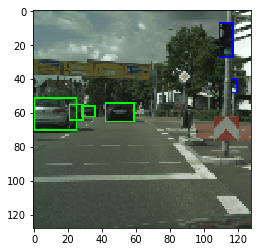

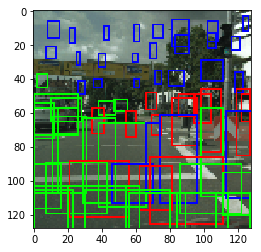

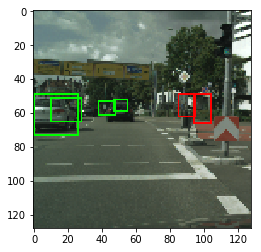

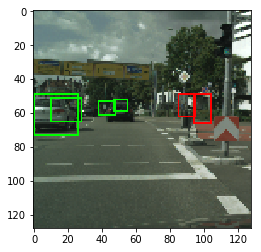

In [26]:
TEST_ID = 32

# Pick and image from the dataset
test_img = hw2_dataset.images[test_ind[TEST_ID]]

# Collect the labels predictions for this image
# Note: the reason we need to do all this stuff is because the preprocessing
# required that we filter each grid-cell to handle at most 1 image
true_flattened = volume_to_flattened_with_grid_indices(hw2_dataset.labels[test_ind[TEST_ID]])
true_filtered = filter_yolo_predictions(true_flattened, 1)
true_dense = flat_with_grid_indices_to_dense(true_filtered)[:, :-1]

# Original image with true labels
original_img_viz = draw_bounding_boxes(test_img, true_dense)

test_input = np.expand_dims(np.transpose(hw2_dataset.images[test_ind[TEST_ID]], (2, 0, 1)), axis=0)
test_input = torch.from_numpy(test_input).to(device=DEVICE, dtype=torch.float)

with torch.no_grad():
  ret = net(test_input)
  ret = ret.squeeze(0)
  ret = torch.sigmoid(ret)

yolo_volume = ret.detach().cpu().numpy()

# Flatten the output YOLO volume to a grid
flattened = volume_to_flattened_with_grid_indices(yolo_volume)

# Filter the YOLO outputs for P(Obj) > 0.6
pobj_filtered = filter_yolo_predictions(flattened, 0.6)

# Densify the YOLO outputs
pobj_filtered_dense = flat_with_grid_indices_to_dense(pobj_filtered)

# NMS on the remaining filtered labels with cluster threshold 0.5
nms_filtered = non_max_suppression(pobj_filtered_dense, cluster_thresh=0.5)

with np.printoptions(precision=3, suppress=True):
  print(true_dense)
  print(nms_filtered)

unf_viz = draw_bounding_boxes(test_img, flat_with_grid_indices_to_dense(filter_yolo_predictions(flattened, 0.0)))
obj_viz = draw_bounding_boxes(test_img, pobj_filtered_dense)
nms_viz = draw_bounding_boxes(test_img, nms_filtered)

plt.imshow(original_img_viz)
# plt.savefig("original_{}.png".format(i), dpi=600)
# files.download("original_{}.png".format(i)) 

plt.figure()
plt.imshow(unf_viz)
# plt.savefig("unfiltered.png", dpi=400)
# files.download("unfiltered.png") 

plt.figure()
plt.imshow(obj_viz)
# plt.savefig("pobj_filtered.png", dpi=400)
# files.download("pobj_filtered.png") 

plt.figure()
plt.imshow(nms_viz)
# plt.savefig("nms_filtered_{}.png".format(i), dpi=400)
# files.download("nms_filtered_{}.png".format(i)) 

# print(filtered_labels)


## Preprocessing Check

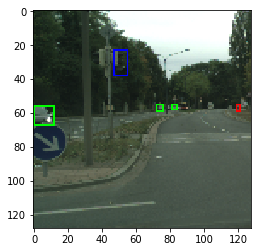

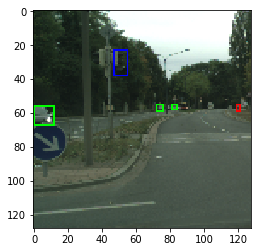

In [27]:
test_img = hw2_dataset.images[17]
original_img_viz = draw_bounding_boxes_dataset(hw2_dataset, 17)

# Orignal labels
test_labels = hw2_dataset.dense_labels[17]

# Preprocess to YOLO labels
yolo_volume = labels_to_dense_yolo_labels(test_labels)

# for channel in range(yolo_volume.shape[0]):
#   print(yolo_volume[channel])

flattened = volume_to_flattened_with_grid_indices(yolo_volume)
filtered = filter_yolo_predictions(flattened, 0.01)

filtered_dense = flat_with_grid_indices_to_dense(filtered)[:, :-1]

recon_img_viz = draw_bounding_boxes(test_img, filtered_dense)

plt.imshow(original_img_viz)
# plt.savefig("original.png", dpi=400)
# files.download("original.png") 

plt.figure()
plt.imshow(recon_img_viz)
# plt.savefig("recon.png", dpi=400)
# files.download("recon.png") 
